# Домашнее задание  
## по теме «Введение в машинное обучение. KNN. Метрики качества. Матрица ошибок. Виды данных (числовые / категориальные)» 

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Проверка типов данных на соответсвие данным в DataFram

In [2]:
df = pd.read_csv('input_data/train.csv') # загрузка DataFrame 
print(df.head()) # Вывод первых строк
print()
df.info(memory_usage=True) # Вывод столбцов и их типов

   id  gravity    ph  osmo  cond  urea  calc  target
0   0    1.013  6.19   443  14.8   124  1.45       0
1   1    1.025  5.40   703  23.6   394  4.18       0
2   2    1.009  6.13   371  24.5   159  9.04       0
3   3    1.021  4.91   442  20.8   398  6.63       1
4   4    1.021  5.53   874  17.8   385  2.21       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


Вывод:
- типы данных соотвествуют
- набор данных не содержит текстовых колонок

### Анализ на пропуски

In [3]:
df_null = df.isna().mean().sort_values()
print(df_null)

id         0.0
gravity    0.0
ph         0.0
osmo       0.0
cond       0.0
urea       0.0
calc       0.0
target     0.0
dtype: float64


Вывод: Набор данных не содержит пропусков

### EDA анализ

In [4]:
numeric_summary = []
for column in df.columns:
    stats = {
        'Параметр': column,
        'Доля пропусков': df[column].isnull().mean(),
        'Максимальное значение': df[column].max(),
        'Минимальное значение': df[column].min(),
        'Среднее значение': df[column].mean(),
        'Медиана': df[column].median(),
        'Дисперсия': df[column].var(),
        'Квантиль 0.1': df[column].quantile(0.1),
        'Квантиль 0.9': df[column].quantile(0.9),
        'Квартиль 1': df[column].quantile(0.25),
        'Квартиль 3': df[column].quantile(0.75)
    }
    numeric_summary.append(stats)

# Вывод результата
for val in numeric_summary:
    print(f"Параметр: {val['Параметр']}")
    for key, value in val.items():
        if key != 'Параметр':
            print(f"    {key}: {value}")
    print()

Параметр: id
    Доля пропусков: 0.0
    Максимальное значение: 413
    Минимальное значение: 0
    Среднее значение: 206.5
    Медиана: 206.5
    Дисперсия: 14317.5
    Квантиль 0.1: 41.300000000000004
    Квантиль 0.9: 371.7
    Квартиль 1: 103.25
    Квартиль 3: 309.75

Параметр: gravity
    Доля пропусков: 0.0
    Максимальное значение: 1.04
    Минимальное значение: 1.005
    Среднее значение: 1.017893719806763
    Медиана: 1.018
    Дисперсия: 4.455526312711286e-05
    Квантиль 0.1: 1.008
    Квантиль 0.9: 1.025
    Квартиль 1: 1.012
    Квартиль 3: 1.022

Параметр: ph
    Доля пропусков: 0.0
    Максимальное значение: 7.94
    Минимальное значение: 4.76
    Среднее значение: 5.955458937198068
    Медиана: 5.74
    Дисперсия: 0.4124979728860348
    Квантиль 0.1: 5.33
    Квантиль 0.9: 6.81
    Квартиль 1: 5.53
    Квартиль 3: 6.28

Параметр: osmo
    Доля пропусков: 0.0
    Максимальное значение: 1236
    Минимальное значение: 187
    Среднее значение: 651.5458937198067
    Медиа

Вывод:
- все столбцы могут быть полезны для модели.
- потребуется масштабирование
- возможны выбросы

In [5]:
# Функция вывода boxplot что бы не плодить код
def boxplot_add(df):
    plt.figure(figsize=(10, 6))
    plt.boxplot([df[col] for col in df.columns], vert=False)
    plt.title('boxplot')  # Заголовок
    plt.xlabel('Значения')  # Подпись оси X
    plt.ylabel('Столбцы')  # Подпись оси Y
    plt.yticks(ticks=np.arange(1, len(df.columns) + 1), labels=df.columns)  # Подписи по оси Y
    return plt
    # plt.show()

### boxplot на начальных данных

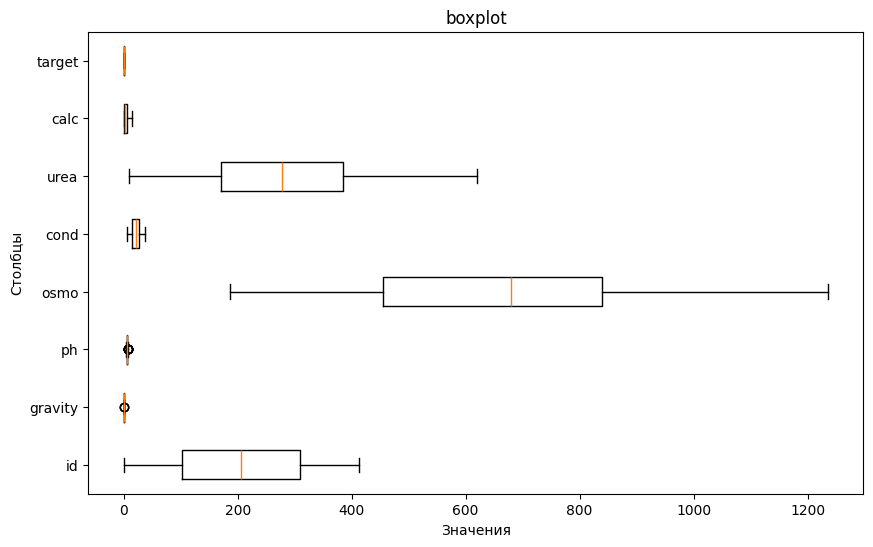

In [6]:
boxplot_add(df).show()

Вывод: Требуется масштабирование

In [7]:
# масштабирование данных
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### boxplot на масштабированных данных

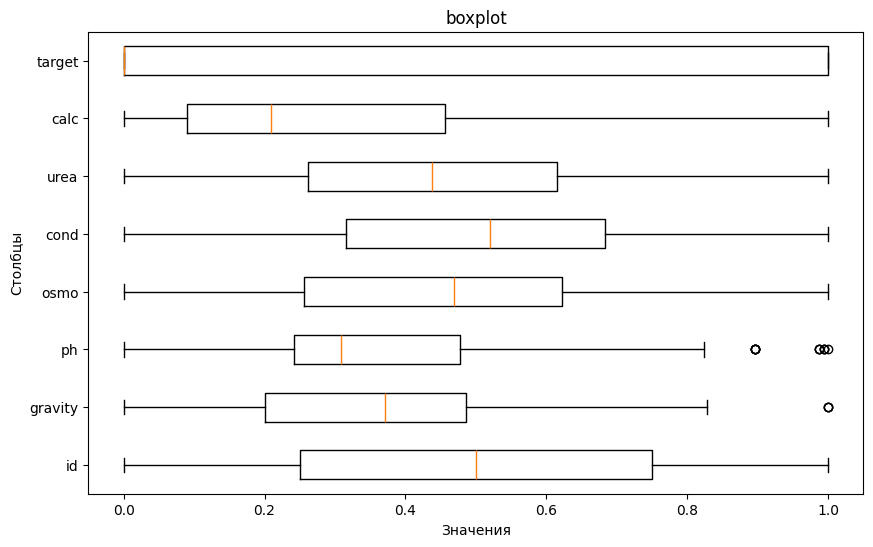

In [8]:
boxplot_add(df_scaled).show()

Вывод: Данные в масштабе. Стали "проявляться" выбросы

### Работа с выбросами

In [9]:
df = df_scaled # Принимаем масштабированные данные

def get_iqr_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Вычисляем границы для каждого столбца
ph_lower, ph_upper = get_iqr_bounds(df['ph'])
gravity_lower, gravity_upper = get_iqr_bounds(df['gravity'])

# Заменяем выбросы в столбце 'ph' на верхнюю границу
df['ph'] = df['ph'].clip(upper=ph_upper)

# Заменяем выбросы в столбце 'gravity' на верхнюю границу
df['gravity'] = df['gravity'].clip(upper=gravity_upper)

### boxplot без выбросов

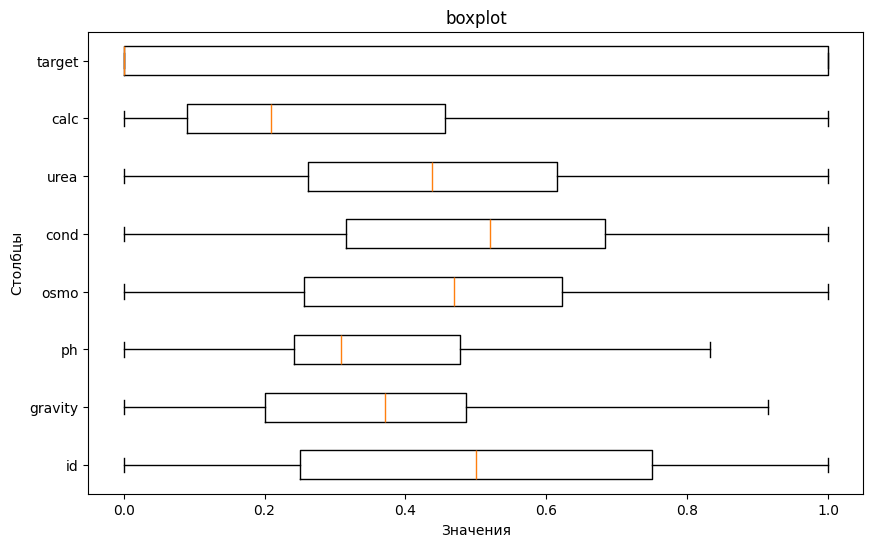

In [10]:
boxplot_add(df).show()

Вывод: 
- Пробовал среднее, мединану и удаление пораждаются новые выбросы. По совету применил замену на верхнюю границу, так как выбросы с право
- Выбросы устранены. Данные готовы для обучения

In [11]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']]  # Признаки
y = df['target']  # Целевая переменная

# Разделяем на обучающую и тестовую выборки
# test_size=0.2 — 20% данных пойдут в тестовую выборку
# random_state=42 — для воспроизводимости результата
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Результат 
# print("Обучающая выборка (X_train):")
# print(X_train)
# print("\nТестовая выборка (X_test):")
# print(X_test)
# print("\nОбучающая выборка (y_train):")
# print(y_train)
# print("\nТестовая выборка (y_test):")
# print(y_test)

### Подбор K

In [12]:
# Подбор k по среднеквардратичному отклонению
k_values = [1, 2, 3, 5, 6, 7, 9, 10, 11, 14, 13, 14, 15, 16, 20] # Список k

mean_scores = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k) # Создание модели k-ближайших соседей

    # Вычисление средней оценки точности с использованием перекрестной проверки
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_scores.append(-1*np.mean(scores))

# Вывод результатов
for k, score in zip(k_values, mean_scores):
    print("k =", k, "mean_squared_error:", score)

k = 1 mean_squared_error: 0.34739936680235184
k = 2 mean_squared_error: 0.26430348258706465
k = 3 mean_squared_error: 0.24034876124428367
k = 5 mean_squared_error: 0.22038353686114878
k = 6 mean_squared_error: 0.22446982260415096
k = 7 mean_squared_error: 0.22002510637905096
k = 9 mean_squared_error: 0.21185598382944987
k = 10 mean_squared_error: 0.2107327001356852
k = 11 mean_squared_error: 0.20910212274465384
k = 14 mean_squared_error: 0.20653135066781125
k = 13 mean_squared_error: 0.20619789701305202
k = 14 mean_squared_error: 0.20653135066781125
k = 15 mean_squared_error: 0.20483964018292378
k = 16 mean_squared_error: 0.2049247724445952
k = 20 mean_squared_error: 0.20606772953414745


Вывод: Лудшие результаты достигаются с K=11. С K=16 результаты ухудшаются

In [13]:
# Кросс-валидация
param_grid = {'n_neighbors': range(1, 21, 5),
              'p': [1, 2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
             scoring='roc_auc')

### Итоги кросс-валидации

In [14]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001179,0.000236,0.001646,0.000291,1,1,"{'n_neighbors': 1, 'p': 1}",0.691892,0.607642,0.621156,0.705965,0.575489,0.640429,0.050213,8
1,0.001000,0.000067,0.001340,0.000059,1,2,"{'n_neighbors': 1, 'p': 2}",0.631532,0.634669,0.651911,0.692451,0.619758,0.646064,0.025373,7
2,0.001003,0.000099,0.001475,0.000087,6,1,"{'n_neighbors': 6, 'p': 1}",0.765766,0.684995,0.769338,0.856011,0.674278,0.750078,0.066061,5
3,0.000959,0.000053,0.001405,0.000078,6,2,"{'n_neighbors': 6, 'p': 2}",0.753604,0.679404,0.759087,0.829916,0.662162,0.736834,0.060522,6
4,0.000911,0.000047,0.001482,0.000102,11,1,"{'n_neighbors': 11, 'p': 1}",0.785135,0.739049,0.731128,0.863933,0.720410,0.767931,0.052838,1
5,0.000919,0.000029,0.001396,0.000057,11,2,"{'n_neighbors': 11, 'p': 2}",0.754054,0.724604,0.733458,0.851351,0.697111,0.752116,0.052881,4
6,0.000933,0.000035,0.001498,0.000090,16,1,"{'n_neighbors': 16, 'p': 1}",0.797748,0.692917,0.723672,0.861137,0.728798,0.760854,0.060734,2
7,0.000985,0.000118,0.001524,0.000129,16,2,"{'n_neighbors': 16, 'p': 2}",0.765766,0.713420,0.726002,0.854147,0.705965,0.753060,0.054592,3


### Лудший результат кросс-валидации

In [15]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)
print(knn_best)

KNeighborsClassifier(n_neighbors=11, p=1)


Вывод: Учитавая в результаты двух эксперименов на подбор k выбираю k=11 p=1.

### Обучение модели на лудших результатах

In [16]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11, p=1)

### Получение метрик

Confusion Matrix Test:
[[35 10]
 [11 27]]
Confusion Matrix Train:
[[152  33]
 [ 43 103]]
Accuracy: 0.7469879518072289 0.770392749244713
Precision: 0.7297297297297297 0.7573529411764706
Recall: 0.7105263157894737 0.7054794520547946
F1_score:  0.7469879518072289
AUC ROC: 0.8188263606071825 0.8078947368421052


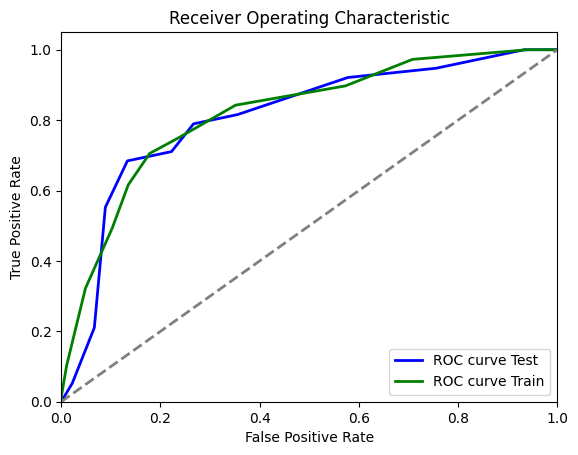

In [17]:
y_test_pred = knn_best.predict(X_test)
y_test_prob = knn_best.predict_proba(X_test)[:, 1]

y_train_pred = knn_best.predict(X_train)
y_train_prob = knn_best.predict_proba(X_train)[:, 1]

# Метрики
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test:")
print(conf_matrix)

conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix Train:")
print(conf_matrix)

print("Accuracy:", accuracy_score(y_test, y_test_pred), accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_test, y_test_pred), precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_test, y_test_pred), recall_score(y_train, y_train_pred))
print("F1_score: ", f1_score(y_test, y_test_pred, average='micro'))
print("AUC ROC:", roc_auc_score(y_train, y_train_prob), roc_auc_score(y_test, y_test_prob))

# Построение ROC кривой
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve Test')
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve Train')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Оценка модели:
- k выбран с учетом двух экспериментов по среднеквадратичному отклонению и кросс-валидации. Приемлемым посчитал k=11 p=1. 
Набор данных небольшой и, на мой взгляд, при большем k возможно переобучение.
- Модель не переобучена (оценка по AUC, для обучающей и тестовой выборок близки) 
- Модель предсказывает с точностью около 75%, использовать для постановки диагноза нельзя, но на УЗИ направление дать можно.